In [72]:
from functools import partial

import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as onp
from scipy.optimize import brentq

import hyperwave.fdtd as fdtd
from hyperwave.utils import at
from hyperwave.typing import Range, Subfield, Volume

### Step 1 - Define the properties of the waveguide

In [73]:
width = 0.5
height = 0.22
n_clad = 1.45 # SiO2 substrate
n_wg = 3.44   # Si waveguide
wl = 1.55

### Step 2 - Define the simulation window size

In [74]:
Lx = 5 * width
Lz = 5 * height
Ly = 4.0
dL = 50e-3

### Step 3 -Define the geometry - SIMPLE EXAMPLE AKA NO AVERAGING

In [75]:
Nx, Ny, Nz = [int(Ll // dL) for Ll in (Lx, Ly, Lz)]

eps = jnp.ones((3, Nx, Ny, Nz)) * n_clad ** 2
xspacing = int((Lx - width) / 2 // dL)
zspacing = int((Lz - height) / 2 // dL)
eps = eps.at[:, xspacing:-xspacing, :, zspacing:-zspacing].set(n_wg ** 2)

### Step 4 - Define the coordinates

In [76]:
xx = jnp.linspace(-Lx/2, Lx/2-dL, Nx)
yy = jnp.linspace(-Ly/2, Ly/2-dL, Ny)
zz = jnp.linspace(-Lz/2, Lz/2-dL, Nz)
grid = (
    jnp.array((xx, xx + dL/2)).T,
    jnp.array((yy, yy + dL/2)).T,
    jnp.array((zz, zz + dL/2)).T,
)

##### We can now plot the structure!

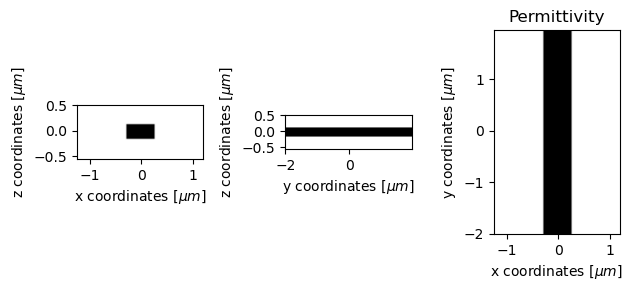

In [77]:
fig, axes = plt.subplots(1, 3)
extent_xz = [min(xx), max(xx), min(zz), max(zz)]
extent_yz = [min(yy), max(yy), min(zz), max(zz)]
extent_xy = [min(xx), max(xx), min(yy), max(yy)]

axes[0].imshow(eps[0, :, Ny // 2, :].T, extent=extent_xz, cmap='Greys')
axes[0].set_xlabel("x coordinates [$\mu m$]")
axes[0].set_ylabel("z coordinates [$\mu m$]")

axes[1].imshow(eps[0, Nx//2, :, :].T, extent=extent_yz, cmap='Greys')
axes[1].set_xlabel("y coordinates [$\mu m$]")
axes[1].set_ylabel("z coordinates [$\mu m$]")

axes[2].imshow(eps[0, :, :, Nz // 2].T, extent=extent_xy, cmap='Greys')
axes[2].set_xlabel("x coordinates [$\mu m$]")
axes[2].set_ylabel("y coordinates [$\mu m$]")

plt.title("Permittivity")
fig.tight_layout()

### Step 5 - Source calculation - Exact profile

From Yariv "Optical Electronics in Modern Communications", Chapter 3.

The mode is solved using the hypothesis of separable equation i.e. it will be solve for the two cross_sections

In [78]:
def get_mode(k0, nclad, ncore, d, xx, N, idw_min):
    V2 = lambda w: (ncore**2 - nclad**2) * (w * k0 / 2)**2
    trans_eq = lambda u, V: V - jnp.square(u) - jnp.square(u * jnp.tan(u))

    V2x = V2(d)
    ux = brentq(lambda x: trans_eq(x, V2x), 0, jnp.pi/2)
    kx = 2 * ux / d
    neffx = onp.sqrt(-kx**2 + (n_wg * k0)**2) / k0

    alpha = kx * jnp.tan(kx * d / 2)
    C = jnp.cos(kx * d / 2) / jnp.exp(-alpha * d / 2)
    D = C

    E_mode = jnp.ones((N,))
    E_mode = E_mode.at[:idw_min].set(D * jnp.exp(alpha * xx[:idw_min]))
    E_mode = E_mode.at[idw_min:-idw_min].set(jnp.cos(kx * xx[idw_min:-idw_min]))
    E_mode = E_mode.at[-idw_min:].set(C * jnp.exp(-alpha * xx[-idw_min:]))

    return E_mode

In [79]:
k0 = 2 * jnp.pi / wl

In [80]:
mode_x = get_mode(k0, n_clad, n_wg, width, xx, Nx, xspacing)
mode_z = get_mode(k0, n_clad, n_wg, height, zz, Nz, zspacing)

mode_full_x = jnp.repeat(jnp.expand_dims(mode_x, 1), Nz, axis=1)
mode_full_z = jnp.repeat(jnp.expand_dims(mode_z, 0), Nx, axis=0)

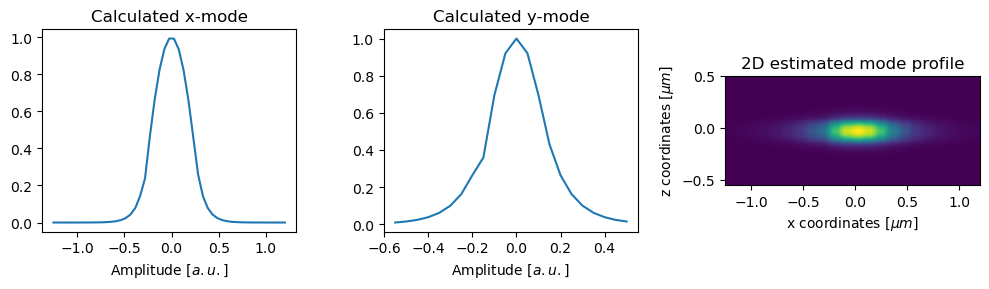

In [81]:
fig, axes = plt.subplots(1,3, figsize=(10,3))

axes[0].plot(xx, mode_x)
axes[0].set_title("Calculated x-mode")
axes[0].set_xlabel("x coordinates [$\mu m$]")
axes[0].set_xlabel("Amplitude [$a.u.$]")

axes[1].plot(zz, mode_z)
axes[1].set_title("Calculated y-mode")
axes[1].set_xlabel("z coordinates [$\mu m$]")
axes[1].set_xlabel("Amplitude [$a.u.$]")

axes[2].imshow(mode_full_x * mode_full_z, extent=[xx[0], xx[-1], zz[0], zz[-1]])
axes[2].set_title("2D estimated mode profile")
axes[2].set_xlabel("x coordinates [$\mu m$]")
axes[2].set_ylabel("z coordinates [$\mu m$]")

fig.tight_layout()

In [82]:
mode = jnp.ones((3, Nx, 1, Nz))

# Add the mode as Ez at 1/4 of the window
mode = mode.at[-1, :, 0 , :].set(mode_full_x * mode_full_z)
src_ypos = Ny // 4
mode_src= Subfield((0, src_ypos, 0,), mode)

##### We can now plot the structure and visualize where is the source

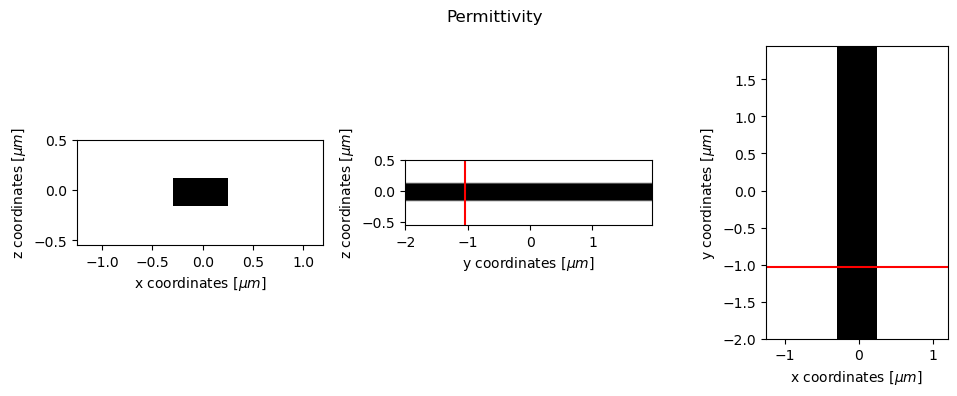

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))
extent_xz = [min(xx), max(xx), min(zz), max(zz)]
extent_yz = [min(yy), max(yy), min(zz), max(zz)]
extent_xy = [min(xx), max(xx), min(yy), max(yy)]

axes[0].imshow(eps[0, :, Ny // 2, :].T, extent=extent_xz, cmap='Greys')
axes[0].set_xlabel("x coordinates [$\mu m$]")
axes[0].set_ylabel("z coordinates [$\mu m$]")

axes[1].imshow(eps[0, Nx//2, :, :].T, extent=extent_yz, cmap='Greys')
axes[1].axvline(yy[src_ypos], color='red')
axes[1].set_xlabel("y coordinates [$\mu m$]")
axes[1].set_ylabel("z coordinates [$\mu m$]")

axes[2].imshow(eps[0, :, :, Nz // 2].T, extent=extent_xy, cmap='Greys')
axes[2].set_xlabel("x coordinates [$\mu m$]")
axes[2].axhline(yy[src_ypos], color='red')
axes[2].set_ylabel("y coordinates [$\mu m$]")

plt.suptitle("Permittivity")
fig.tight_layout()

### Step 6 - Boundary conditions calculation

In [84]:
conductivity = jnp.zeros_like(eps)

### Step 7 - Simulate

In [96]:
dt = 0.99 * jnp.min(eps) / jnp.sqrt(3)
# tmax = 1e-11
# Ntmax = 1e5
Ntmax = 4
tt = jnp.arange(0, Ntmax) * dt

outp_volume1 = Volume(offset=(0, src_ypos + 2, 0), shape=(Nx, 1, Nz))
outp_volume2 = Volume(offset=(0, Ny - src_ypos, 0), shape=(Nx, 1, Nz))
outp_range = Range(1, 100, int(tt[-1] // dt))

mode_temp = jnp.exp(-jnp.square((tt - len(tt)* 2/5) / 1e4))

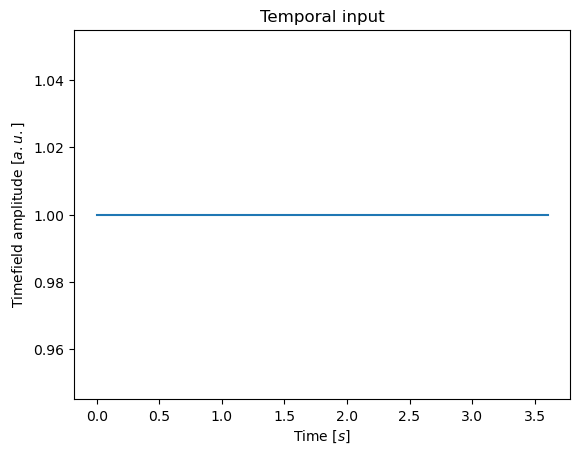

In [97]:
plt.plot(tt, mode_temp)
plt.xlabel("Time [$s$]")
plt.ylabel("Timefield amplitude [$a.u.$]")
plt.title("Temporal input")
plt.show()

In [98]:
state, outs = fdtd.simulate(
    dt=dt,
    grid=grid,
    permittivity=eps,
    conductivity=conductivity,
    source_field=mode_src,
    source_waveform=mode_temp,
    output_volumes=(outp_volume1, outp_volume2),
    snapshot_range=outp_range,
)

### Step 8 - Plot results

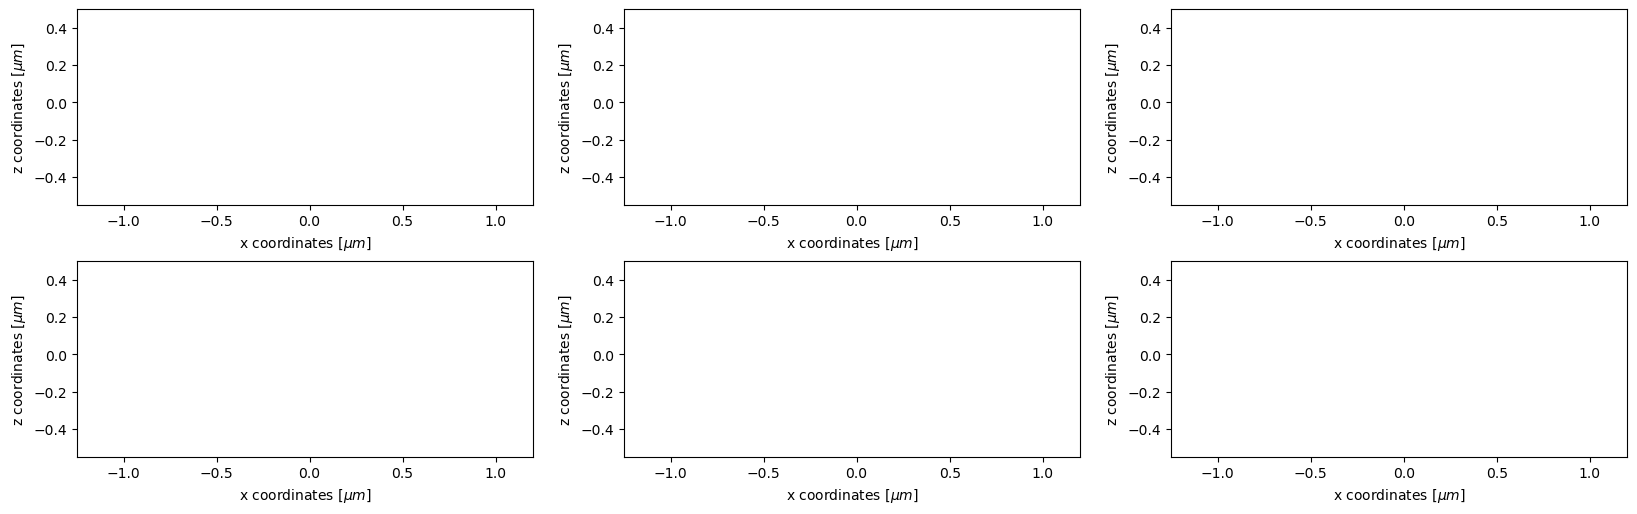

In [121]:
fig, axes = plt.subplots(2, 3, figsize=(20, 6))
for idax in range(len(axes.flatten())):
    iout, idir = idax // 3, idax % 3
    axes[iout,idir].imshow(
        outs[iout][-1].squeeze()[idir],
        extent=extent_xz,
    )
    axes[iout,idir].set_xlabel("x coordinates [$\mu m$]")
    axes[iout,idir].set_ylabel("z coordinates [$\mu m$]")
plt.show()